In [1]:
import pandas as pd
import os
import re
from datetime import datetime, timedelta
import cv2
import numpy as np
import matplotlib.pyplot as plt
from image_points import *
from read_positions import read_positions
import largestinteriorrectangle as lir
%matplotlib inline

def show(img):
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # change channels order since the YOLO work on BGR images


In [2]:
df = read_positions(label_dir='../../data/labels', output_csv='positions.csv')
df = df[df['Camera']==1]

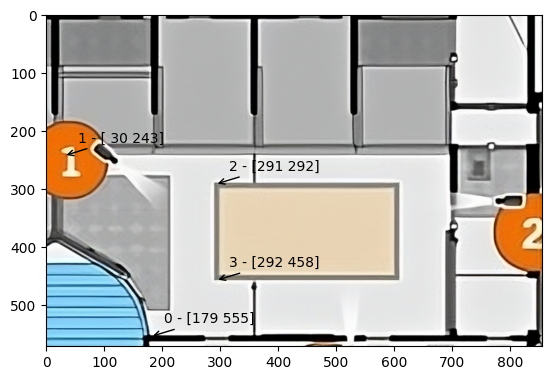

In [3]:
background = cv2.imread('back.jpeg')
show(background)
for i, pt in enumerate(MAP_PTS_1):
    plt.annotate(str(i) + " - " + str(pt), xy=pt, textcoords="offset points", xytext=(10,10), arrowprops=dict(arrowstyle="->"))

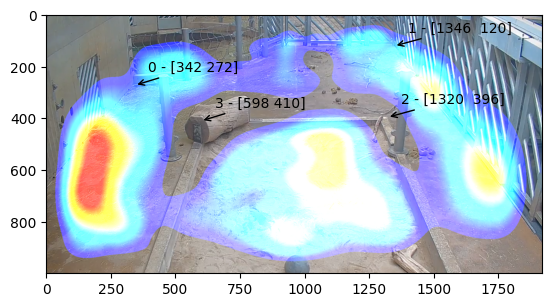

In [4]:
img = cv2.imread('heat.png')
show(img)
for i, pt in enumerate(IMAGE_PTS_1):
    plt.annotate(str(i) + " - " + str(pt), xy=pt, textcoords="offset points", xytext=(10,10), arrowprops=dict(arrowstyle="->"))

In [14]:
H, mask = cv2.findHomography(IMAGE_PTS_1, MAP_PTS_1)
df

,Camera,Date,X_center,Y_center,Width,Height
22,1,2024-01-24 14:15:00,0.840104,0.5300,0.308333,0.524
23,1,2024-01-24 14:15:00,0.779948,0.2885,0.209896,0.365
36,1,2024-01-27 04:15:00,0.597135,0.7150,0.249479,0.562
37,1,2024-01-27 04:15:00,0.485677,0.5800,0.315104,0.334
112,1,2024-01-27 04:00:00,0.601302,0.7155,0.243229,0.553
...,...,...,...,...,...,...
2799,1,2024-01-27 07:00:00,0.616146,0.0935,0.087500,0.155
2800,1,2024-01-27 07:00:00,0.541667,0.0930,0.072917,0.168
2822,1,2024-01-27 04:30:00,0.560156,0.7665,0.261979,0.465
2823,1,2024-01-27 04:30:00,0.415885,0.6000,0.164062,0.340


In [12]:
def transform_box(M, x, y, width, height):
    # x, y = x*1920, y*1000
    # width, height = width*1920, height*1000
    def transform_point(M, x, y):
        points = np.array([[x, y]], dtype='float32')  
        points_reshaped = np.array([points])
        pointsOut = cv2.perspectiveTransform(points_reshaped, H)
        return pointsOut[0,0,0], pointsOut[0,0,1]

    x_proj, y_proj = transform_point(M, x, y)
    
    left, right = x - width/2, x + width/2
    up, down = y - height/2, y + height/2
    
    # left_prime = transform_point(M, left, y)
    # right_prime = transform_point(M, right, y)
    # width_prime = np.linalg.norm(np.array(left_prime)-np.array(right_prime))/1.5
    upper_left_proj = transform_point(M, left, up)
    upper_right_proj = transform_point(M, right, up)
    lower_left_proj = transform_point(M, left, down)
    lower_right_proj = transform_point(M, right, down)
    polygon = np.array([[upper_left_proj, upper_right_proj, lower_right_proj, lower_left_proj]], np.int32)
    print(f'POLYGON {polygon}')
    rectangle = lir.lir(polygon)
    x_proj, y_proj, width_proj, height_proj = rectangle
    x_proj += width_proj//2
    y_proj += height_proj//2
    # leftiest_x = min(upper_left_proj[0], upper_right_proj[0], lower_left_proj[0], lower_right_proj[0])
    # rightiest_x = max(upper_left_proj[0], upper_right_proj[0], lower_left_proj[0], lower_right_proj[0])

    # highest_y = min(upper_left_proj[1], upper_right_proj[1], lower_left_proj[1], lower_right_proj[1])
    # lowest_y = max(upper_left_proj[1], upper_right_proj[1], lower_left_proj[1], lower_right_proj[1])

    # assert leftiest_x <= x_proj <= rightiest_x
    # assert highest_y <= y_proj <= lowest_y
    
    # width_proj = rightiest_x - leftiest_x
    # height_proj = lowest_y - highest_y
    return x_proj, y_proj, width_proj, height_proj


In [16]:
IMG_WIDTH, IMG_HEIGHT = 1920, 1000 

df_proj = pd.DataFrame(columns=['Camera', 'Date', 'X_center', 'Y_center', 'Width', 'Height'])
for index, row in df.iterrows():
    data = {}
    data['Camera'] = row['Camera']
    data['Date'] = row['Date']
    x, y, width, height = row['X_center'], row['Y_center'], row['Width'], row['Height']
    x, y = x*IMG_WIDTH, y*IMG_HEIGHT
    width, height = width*IMG_WIDTH, height*IMG_HEIGHT
    print(f'x, y, w, h = {x, y, width, height}')
    x_proj, y_proj, width_proj, height_proj = transform_box(H, x, y, width, height)
    print(f'x, y, w, h = {x_proj, y_proj, width_proj, height_proj}')
    break
    
    data['X_center'], data['Y_center'], data['Width'], data['Height'] = transform_box(H, row['X_center'], row['Y_center'], row['Width'], row['Height'])
    # print(data)
    df_proj = pd.concat([df_proj, pd.DataFrame([data])], ignore_index=True)
    break
df_proj

x, y, w, h = (1612.99968, 530.0, 591.99936, 524.0)
POLYGON [[[196 278]
  [208 129]
  [453 231]
  [453 317]]]
[202 201 181  79]
x, y, w, h = (292, 240, 181, 79)


,Camera,Date,X_center,Y_center,Width,Height


572 856


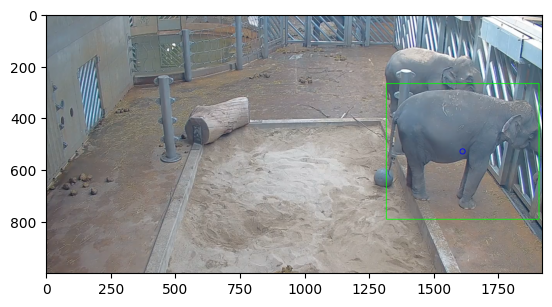

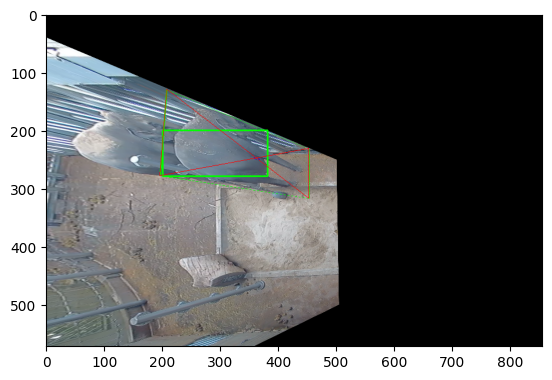

In [17]:
def plot_rectangle_on_image(image, cx, cy, w, h, color=(0, 255, 0), thickness=2):
    """
    Draws a rectangle on an image based on the center coordinates, width, and height.

    Parameters:
    - image: The image (numpy array) on which to draw.
    - cx, cy: The center coordinates of the rectangle.
    - w, h: The width and height of the rectangle.
    - color: The color of the rectangle (BGR format).
    - thickness: The thickness of the rectangle's outline. Use -1 for filled rectangle.
    """
    # Calculate the top-left corner of the rectangle
    top_left_x = int(cx - w / 2)
    top_left_y = int(cy - h / 2)

    # Calculate the bottom-right corner of the rectangle
    bottom_right_x = int(cx + w / 2)
    bottom_right_y = int(cy + h / 2)

    # Draw the rectangle on the image
    cv2.rectangle(image, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), color, thickness)
def draw_circle_at_exact_position(image, x, y, radius=10, color=(0, 255, 0), thickness=2):
    """
    Draw a small circle on the image at a relative position.

    Parameters:
    - image: The image on which to draw the circle (numpy array).
    - rel_x: The relative x coordinate (from 0 to 1) where to draw the circle.
    - rel_y: The relative y coordinate (from 0 to 1) where to draw the circle.
    - radius: The radius of the circle (in pixels).
    - color: The color of the circle (B, G, R) format.
    - thickness: The thickness of the circle's outline. Use a negative value for a filled circle.
    """
    # Calculate actual pixel coordinates# Draw the circle
    cv2.circle(image, (int(x), int(y)), radius, color, thickness)

# Example usage:
image = cv2.imread('../../data/images/screenshot1_24_01__11_15.png')
plot_rectangle_on_image(image, 1612.99968, 530.0, 591.99936, 524.0)
draw_circle_at_exact_position(image, 1612.99968, 530.0, 10, (255,0,0))
show(image)
# Plot a rectangle on the image
# plot_rectangle_on_image(image, cx=100, cy=150, w=50, h=100, color=(255, 0, 0), thickness=2)

# Show the image with the rectangle
# cv2.imshow('Image with Rectangle', image)
height, width = background.shape[:2]
print(height, width)
dst = cv2.warpPerspective(image, H, (width, height))
plot_rectangle_on_image(dst,292, 240, 181, 79)
polygon = np.array([[196, 278],
  [208, 129],
  [453, 317],
  [453, 231]])
cv2.polylines(dst, [polygon], True, (0, 0, 255), 1)

show(dst)

In [ ]:
def get_heatmap_new(df, camera):
    df = df[df['Camera'] == camera]

    # Specify the dimensions of the heatmap
    heatmap_width, heatmap_height = 856, 572

    # Initialize a blank image for the heatmap
    heatmap_img = np.zeros((heatmap_height, heatmap_width), dtype=np.float32)

    # Function to apply intensity within the bounding box area
    def apply_bounded_gaussian_heatmap(cx, cy, w, h, heatmap):
        # Calculate the bounding box in pixel coordinates
        left = int(max(0, cx - w * heatmap_width / 2))
        right = int(min(heatmap_width, cx + w * heatmap_width / 2))
        top = int(max(0, cy - h * heatmap_height / 2))
        bottom = int(min(heatmap_height, cy + h * heatmap_height / 2))

        sigma_x = w * heatmap_width / 6
        sigma_y = h * heatmap_height / 6

        # Apply intensity only within the bounding box, using a Gaussian distribution
        for y in range(top, bottom):
            for x in range(left, right):
                dx = cx - x
                dy = cy - y
                value = np.exp(-(dx ** 2 / (2 * sigma_x ** 2) + dy ** 2 / (2 * sigma_y ** 2)))
                heatmap[y, x] += value

    # Populate the heatmap with bounded Gaussian distribution
    for index, row in df.iterrows():
        cx, cy, w, h = row['X_center'] * heatmap_width, row['Y_center'] * heatmap_height, row['Width'], row['Height']
        apply_bounded_gaussian_heatmap(cx, cy, w, h, heatmap_img)

    # Normalize the heatmap
    cv2.normalize(heatmap_img, heatmap_img, 0, 255, norm_type=cv2.NORM_MINMAX)
    zero_mask = (heatmap_img < 20)
    # Apply a colormap to create a color heatmap
    heatmap_color = cv2.applyColorMap(np.uint8(heatmap_img), cv2.COLORMAP_JET)
    heatmap_color[zero_mask] = (0,0,0)
    # plt.figure()
    # plt.imshow(heatmap_color[..., ::-1])  # change channels order since the YOLO work on BGR images
    # plt.show()
    return heatmap_color
